In [1]:
#imports
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import scipy as sp
import scipy.linalg as spl
import scipy.stats as sps

import pandas as pd

import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from our_package import * #allows us to use our functions directly

In [5]:
### we call the different functions
T = 5
Lambda = 1
Lambdas = [0.1] + [0.5*i for i in range(1,10)] + [7.5,10]
Y_simu=Create_DicoY(T,Lambdas)
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
sh = Buildsh(T)
Y = Y_simu[Lambda]
x,x_tilde = ComputeArgmax(T,Lambda, Y)
mu,mu_tilde = ComputeMeans(T,Lambda, Y)
q1 = ComputeQuantiles(T,Lambda,0.975*np.ones(T), Y)
q2 = ComputeQuantiles(T,Lambda,0.025*np.ones(T), Y)
med = ComputeQuantiles(T,Lambda,0.5*np.ones(T), Y)
sim_theta,sim_theta_tilde,sim_accepts,sim_gammas, Mean, End = MetropolisHastings(T,Lambda, Y, 1e5, "source")
#Mean=np.sum(sim_theta,axis=0)/sim_theta.shape[0]
q = np.array([2.5,50,97.5])
quantiles_emp = Quantiles(sim_theta_tilde, q,T)
quantiles2=Quantiles(sim_theta_tilde,q,T)

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
C:\Users\vetle\AppData\Local\Temp\ipykernel_25024\3051564969.py:8: SyntaxWarning: invalid escape sequence '\p'
  axes[0].set_title("Theoritical results for $\pi$ tilde")
C:\Users\vetle\AppData\Local\Temp\ipykernel_25024\3051564969.py:17: SyntaxWarning: invalid escape sequence '\p'
  axes[1].set_title("Empirical results for $\pi$ tilde")


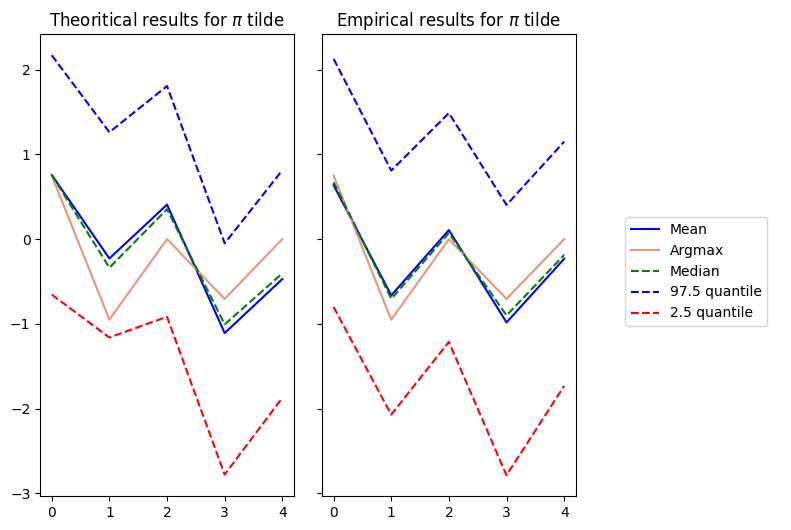

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharey=True)
#Plot of theoritical results
axes[0].plot(mu_tilde,color="blue",label="Mean")
axes[0].plot(x_tilde,color="darksalmon",label="Argmax")
axes[0].plot(med,'g--',label="Median")
axes[0].plot(q1,'b--',label="97.5 quantile")
axes[0].plot(q2,'r--',label="2.5 quantile")
axes[0].set_title("Theoritical results for $\pi$ tilde")


#Plot of empirical results
axes[1].plot(D@Mean,color="blue")
axes[1].plot(x_tilde,color="darksalmon")
axes[1].plot(quantiles_emp[1],'g--')
axes[1].plot(quantiles_emp[2],'b--')
axes[1].plot(quantiles_emp[0],'r--')
axes[1].set_title("Empirical results for $\pi$ tilde")


# Shrink current axis by 20%
box0,box1 = axes[0].get_position(),axes[1].get_position()
axes[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
axes[1].set_position([box1.x0*0.8, box1.y0, box1.width * 0.8, box1.height])
fig.legend(loc=(0.8*box1.x0+box1.width,box1.height/2))
plt.show()

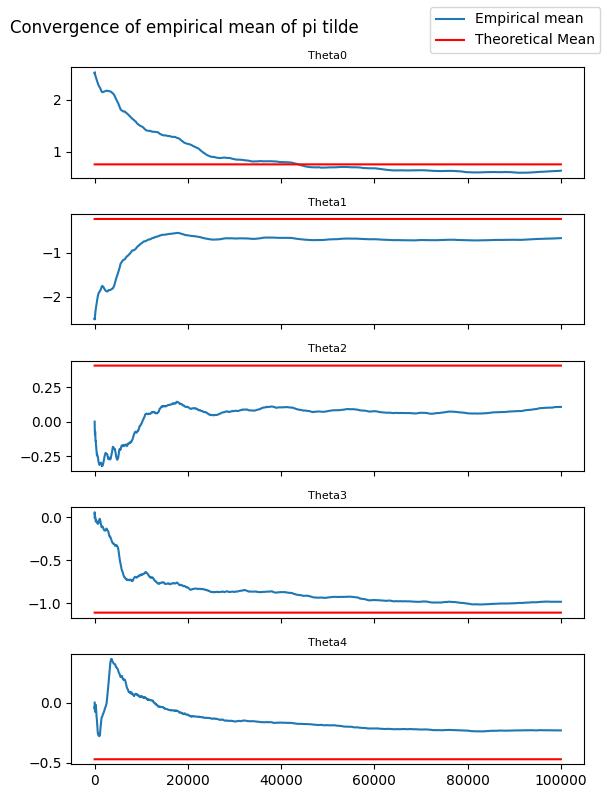

In [11]:
#Convergence plot of the mean of theta_tilde
nb_save=sim_theta.shape[0]
x=np.linspace(1,nb_save,nb_save)
mean_tab=np.cumsum(sim_theta_tilde,axis=0)

fig,Axes = plt.subplots(T,1,figsize=(6,8),sharex=True)
for i in range(T):
    ax = Axes[i]
    res=mean_tab[:,i]/x
    ax.plot(x,res,label="Empirical mean" if i==0 else "")
    ax.plot(x,mu_tilde[i]*np.ones(nb_save),'r',label="Theoretical Mean" if i==0 else "")
    ax.set_title(f"Theta{i}",fontsize=8)

fig.suptitle("Convergence of empirical mean of pi tilde", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

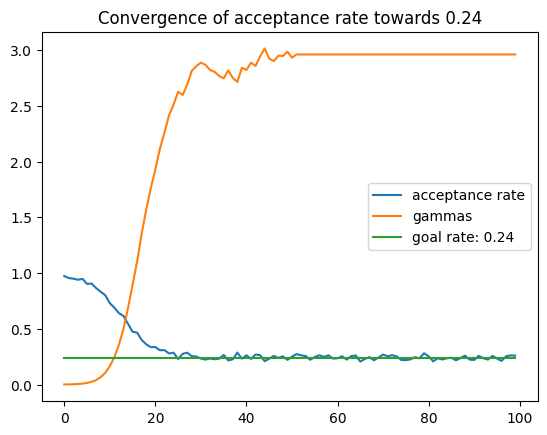

In [12]:
plt.plot(sim_accepts,label="acceptance rate")
plt.plot(sim_gammas[:-1],label="gammas")
plt.plot(np.ones(len(sim_accepts))*0.24,label="goal rate: 0.24")
plt.title("Convergence of acceptance rate towards 0.24")
plt.legend()
plt.show()

In this part of the notebook, we will estimate $\theta$ under different $\lambda \in \Lambda$. We define a list containing different $\lambda$ and we will create a DataFrame that computes the relative error for every component of $\theta$ 10 times, and we will look at the mean and standard deviation of the relative error for every component.

In [13]:
Lambdas = [0.1] + [0.5*i for i in range(1,10)] + [7.5,10]#np.arange(0.5,5,0.5)#[0.1,0.5,0.8,1,1.3,1.6,2,4,7,9]
T = 5
niter = 1e5
nb_sim = 10
method = "source"
n = len(Lambdas)
sim_theta_tildes = np.zeros((T,10,n))

for k in range(n):
    Y = Y_simu[Lambdas[k]]
    for j in range(nb_sim):
        _, sim_theta_tildes[:,j,k] = MetropolisHastingsFast(T, Lambdas[k], Y,niter=niter,method=method)
        print("working...")
    print(f"Oooh yeah! Finished {k}. iteration")

working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 0. iteration
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 1. iteration
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 2. iteration
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 3. iteration
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 4. iteration
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 5. iteration
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
Oooh yeah! Finished 6. iteration

In [14]:
print(pd.DataFrame(sim_theta_tildes[:,:,-1]))

          0         1         2         3         4         5         6  \
0  1.890658  2.650704  1.884185  1.243562  1.638963  1.923110  2.161689   
1 -0.986237 -0.960065 -0.981857 -1.004042 -0.977951 -0.979843 -0.980208   
2 -0.037778 -0.017240 -0.018402 -0.038351 -0.029314 -0.032868 -0.025223   
3 -0.009034  0.002400 -0.001374 -0.016436 -0.009012 -0.011199 -0.012340   
4 -0.003665  0.003042  0.002401 -0.006628 -0.004140  0.002099 -0.001657   

          7         8         9  
0  1.501494  3.121662  2.110044  
1 -0.987524 -0.965013 -0.983570  
2 -0.030108 -0.015879 -0.030763  
3 -0.018467 -0.004213 -0.013538  
4 -0.004598 -0.002552 -0.005502  


The simulated $\theta$ sometimes takes tiny values close to 0, although the theoretical value is a bigger real number. This means that the relative error can exaggerate the magnitude of the error, since we divide by a small number. Therefore we opt for the following error:
$d(x,y) = \frac{|x-y|}{max(|x|,|y|}$

In [15]:
def dist(x,y):
    return np.abs(x-y)/np.maximum(np.abs(x),np.abs(y))

In [16]:
a = np.array([1,2,3,4])
b = np.array([3,4,8,9])
dist(a,b)

array([0.66666667, 0.5       , 0.625     , 0.55555556])

In [17]:
errors = np.zeros(np.shape(sim_theta_tildes))
for k in range(n):
    Y = Y_simu[Lambdas[k]]
    _, theoretical_means = ComputeMeans(T, Lambdas[k], Y)
    errors[:,:,k] = dist(sim_theta_tildes[:,:,k],theoretical_means[:,np.newaxis] @ np.ones((1,nb_sim)))
    #errors[:,:,k] = abs(sim_theta_tildes[:,:,k] - theoretical_means[:,np.newaxis] @ np.ones((1,10))) / np.max(np.abs(sim_theta_tildes[:,:,k])

In [18]:
print(np.shape(errors))
data = np.zeros((T,2*n))
for i in range(n//2+1):
    data[:,2*i] = np.mean(errors[:,:,i],axis=1)
    data[:,2*i+1]=np.std(errors[:,:,i],axis=1)
assert np.shape(data)==(T,2*n)
df = pd.DataFrame(data)

df.columns = pd.MultiIndex.from_product([Lambdas,["mean","std"]],names=["lambdas","measure"])
df

(5, 10, 12)


lambdas      0.1                 0.5                 1.0                 1.5   \
measure      mean       std      mean       std      mean       std      mean   
0        0.186063  0.131679  0.267960  0.087931  0.110732  0.078916  0.099946   
1        0.242283  0.107338  0.126232  0.110820  0.511077  0.109267  0.801089   
2        0.067584  0.038183  0.213459  0.081709  0.512064  0.091854  0.422916   
3        0.074317  0.042858  0.266013  0.064510  0.170713  0.041457  0.631664   
4        0.053554  0.013752  0.374384  0.081423  0.485618  0.053414  0.379139   

lambdas                2.0             ... 3.5       4.0       4.5       7.5   \
measure       std      mean       std  ... mean  std mean  std mean  std mean   
0        0.063626  0.116557  0.049094  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        0.274570  0.290224  0.028115  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        0.056652  0.495572  0.045019  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        0.041812  0.177827  0.028931  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        0.015545  0.045347  0.005999  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

lambdas      10.0       
measure  std mean  std  
0        0.0  0.0  0.0  
1        0.0  0.0  0.0  
2        0.0  0.0  0.0  
3        0.0  0.0  0.0  
4        0.0  0.0  0.0  

[5 rows x 24 columns]

In [19]:
errors[:,:,-1]

array([[0.36409499, 0.10846088, 0.36627231, 0.58173977, 0.44875047,
        0.35318002, 0.27293652, 0.49498663, 0.04756602, 0.29030666],
       [0.10500226, 0.08060361, 0.10100936, 0.12087378, 0.09741848,
        0.09916132, 0.0994971 , 0.10616877, 0.08531833, 0.10257541],
       [1.00395566, 1.00180518, 1.00192683, 1.00401566, 1.00306944,
        1.00344158, 1.0026411 , 1.0031526 , 1.00166263, 1.00322117],
       [1.00091077, 0.99975807, 1.00013855, 1.00165711, 1.00090859,
        1.00112913, 1.00124413, 1.00186189, 1.00042479, 1.00136487],
       [1.00036687, 0.9996955 , 0.99975963, 1.00066349, 1.0004144 ,
        0.99978993, 1.00016582, 1.00046027, 1.0002554 , 1.00055074]])

In [20]:
df_mean = df.mean()


<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\vetle\AppData\Local\Temp\ipykernel_25024\3703065398.py:4: SyntaxWarning: invalid escape sequence '\l'
  fig.suptitle(f"Error as function of $\lambda$, @{niter:.1E} iterations, using method: {method}")


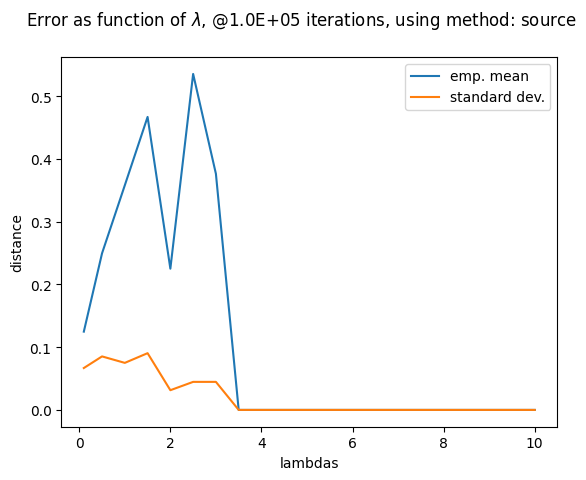

In [21]:
fig,ax = plt.subplots(1,1)
df_mean.xs("mean", level=1, axis=0).plot(label="emp. mean")
df_mean.xs("std",  level=1, axis=0).plot(label="standard dev.")
fig.suptitle(f"Error as function of $\lambda$, @{niter:.1E} iterations, using method: {method}")
ax.set_ylabel("distance")
ax.legend()
plt.show()

# Quand lambda devient trop grand, la pénalité attribuée à la valeur de la dérivée seconde devient trop importante et bloque la 
# dérivée seconde à 0, le comportement devient constant d'où l'absence d'erreurs ?

In [25]:
print(T)
print(a)
print(b)

5
[1 2 3 4]
[3 4 8 9]


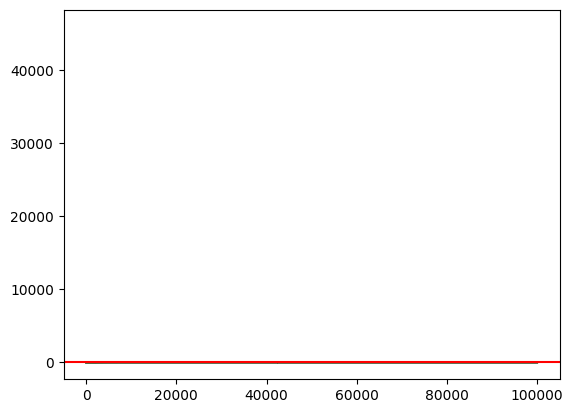

In [27]:
plt.figure()
#print(sim_theta)
#print(LogDistributionPi_Tab(sim_theta, Y, A, D, sh, Lambda))
T = 5
Lambda = 1
D = BuildD(T)
U, Delta, Vt = BuildUVDelta(D)
A = BuildA(Delta, Vt)
assert T!=1
sh = Buildsh(T)

Y = Computation_Y(T, Lambda)
theta_tab, theta_tilde_tab, accepts, gammas, theta_mean, L1_tab, L2_tab, LogPi_tab = MetropolisHastingsFull(T, Lambda, Y)
plt.plot(LogPi_tab, color = "blue")
plt.plot(L1_tab, color = "green")
plt.plot(L2_tab, color = "black")
plt.axhline(LogDistributionPi(ComputeArgmax(T, Lambda, Y)[0], Y, A, D, sh, Lambda), color = "red")
plt.show()

Hopefully, the LogPi Distibution of the chain is always lower than the LogPi of the Argmax (as it is the maximum value).

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\vetle\AppData\Local\Temp\ipykernel_25024\2804298364.py:14: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle("Accuracy of simulation and argmax for $\pi$ distribution", x=0.3)


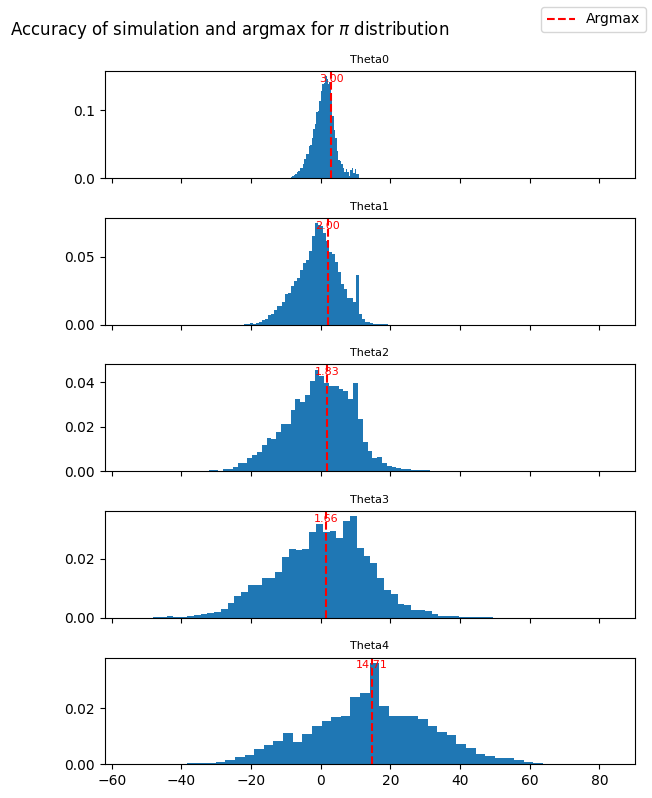

In [28]:
fig, axes = plt.subplots(nrows=T, ncols=1, figsize=(6, 8), sharex=True)
nb_save=theta_tab.shape[0]
argmax=ComputeArgmax(T, Lambda, Y)[0]
for i in range(T):
    ax = axes[i]
    ax.hist(theta_tab[:,i],bins=50,density=True)
    ax.plot(argmax[i],0,color='red')
    ax.axvline(argmax[i], color='red', linestyle='dashed', label="Argmax" if i==0 else "")
    ax.text(argmax[i], ax.get_ylim()[1] * 0.9, f"{argmax[i]:.2f}", 
            color='red', fontsize=8, ha='center')
    ax.set_title(f"Theta{i}",fontsize=8)


fig.suptitle("Accuracy of simulation and argmax for $\pi$ distribution", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

We can see that for the first components, the distibution of the simulation is quite well gaussian and we find quite well the argmax but as we increase the dimensions, this becomes less and less accurate, the distribution variance increases very fast and the distribution of the simulation seems to diverge to the real one as the argmax is not anymore equal to the graphic one.

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\vetle\AppData\Local\Temp\ipykernel_25024\460066343.py:14: SyntaxWarning: invalid escape sequence '\p'
  fig.suptitle("Accuracy of simulation and argmax for $\tilde\pi$ distribution", x=0.3)


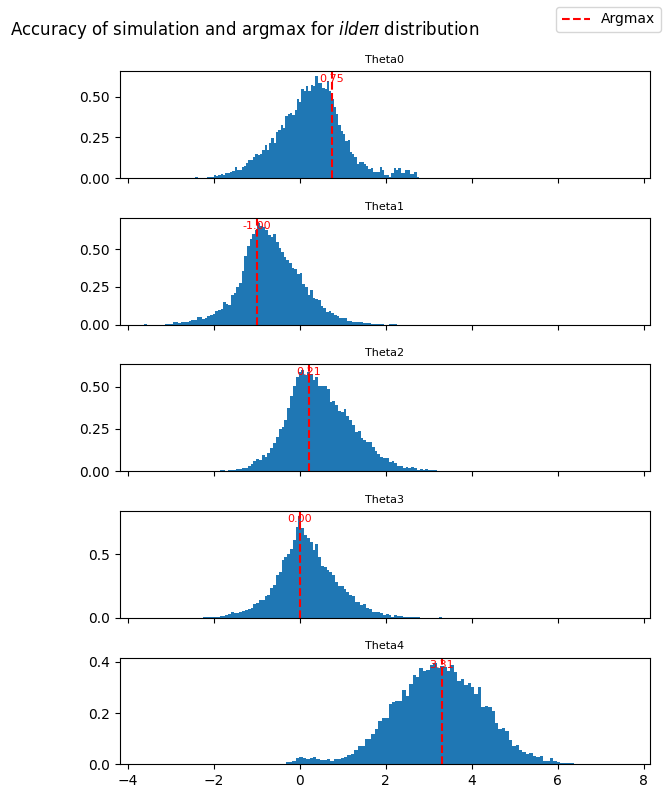

In [29]:
fig, axes = plt.subplots(nrows=T, ncols=1, figsize=(6, 8), sharex=True)
nb_save=theta_tab.shape[0]
argmax=ComputeArgmax(T, Lambda, Y)[1]
for i in range(T):
    ax = axes[i]
    ax.hist(theta_tilde_tab[:,i],bins=100,density=True)
    ax.plot(argmax[i],0,color='red')
    ax.axvline(argmax[i], color='red', linestyle='dashed', label="Argmax" if i==0 else "")
    ax.text(argmax[i], ax.get_ylim()[1] * 0.9, f"{argmax[i]:.2f}", 
            color='red', fontsize=8, ha='center')
    ax.set_title(f"Theta{i}",fontsize=8)


fig.suptitle("Accuracy of simulation and argmax for $\tilde\pi$ distribution", x=0.3)
fig.tight_layout()
fig.legend()
plt.show()

The result is better for the $\tilde\pi$ distribution, the symmetry and variance stay quite the same for every component and the graphic argmax is in accordance with the theoritical one.

In [22]:
(A.T@A).shape[0]

5

In [7]:
CalculDrift(sim_theta[-1,:], 0.05, Lambdas[0], A, Y, D, sh)

array([ 1.70605696,  0.24336586, -0.1420115 , -1.44599783,  0.10217597])

In [10]:
T = 5
Lambdas = [0.1] + [0.5*i for i in range(1,10)] + [7.5,10]
Y_simu=Create_DicoY(T,Lambdas)
n_simu = len(Lambdas)
theoretical_means = np.zeros((n_simu, T))
errors_source = np.zeros(n_simu)
errors_image = np.zeros(n_simu)
errors_subdiff_source = np.zeros(n_simu)
errors_subdiff_image = np.zeros(n_simu)
errors_prox_source = np.zeros(n_simu)
errors_prox_image = np.zeros(n_simu)

for i in range(n_simu):
    print(ComputeMeans(T, 1, Y_simu[Lambdas[i]])[0])
    theoretical_means[i,:] = ComputeMeans(T, 1, Y_simu[Lambdas[i]])[0]
    errors_prox_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="prox_source")[0]-theoretical_means[i,:]))
    errors_prox_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="prox_image")[0]-theoretical_means[i,:]))
    errors_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="source")[0]-theoretical_means[i,:]))
    errors_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="image")[0]-theoretical_means[i,:]))
    errors_subdiff_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="subdiff_source")[0]-theoretical_means[i,:]))
    errors_subdiff_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="subdiff_image")[0]-theoretical_means[i,:]))
    # errors_prox_source[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="prox_source")[0]-theoretical_means[i,:]))
    # errors_prox_image[i] = sum(abs(MetropolisHastingsFast(T, 1, Y_simu[Lambdas[i]], niter=1e5, method="prox_image")[0]-theoretical_means[i,:]))
plt.figure()
plt.plot(errors_source, color = "blue", label="MH source")
plt.plot(errors_image, color = "green", label="MH image")
plt.plot(errors_subdiff_source, color = "red", label="MH Subdiff source")
plt.plot(errors_subdiff_image, color = "black", label="MH Subdiff image")
plt.plot(errors_prox_source, color = "cyan", label="MH Prox source")
plt.plot(errors_prox_image, color = "purple", label="MH Prox image")
plt.legend()
plt.show()

[1.86181736 3.87030816 3.77239916 6.1605146  4.54942149]


C:\Users\vetle\OneDrive\Dokumenter\4MIC-S2\mcmc-epidemic\our_package.py:404: RuntimeWarning: invalid value encountered in scalar add
  log_alpha = -1/2*(npl.norm(U@Y - D@candidate)**2 - Lambda*npl.norm(candidate + sh, ord=1)) + 1/2*(npl.norm(U@Y - theta)**2 - Lambda*npl.norm(theta + sh,ord=1)) - 1/(4*gamma)*npl.norm(candidate - CalculDrift(theta))**2 + 1/(4*gamma)*npl.norm(theta - CalculDrift(candidate))**2


[-3.25001978 -5.39922693 -4.72031487 -6.26060538 -8.95687237]
[3.03047789 5.14888343 8.89684985 8.2117959  5.64323463]
[ 14.87446907  32.75921211  54.5814913   78.77186192 106.42943786]
[ 16.85938808  30.74499961  48.86666146  75.53879392 133.89785119]
[  0.4135553   -5.65270278 -13.05461164 -16.63802215 -18.85215546]
[12.22320081 18.59429315 29.90051204 38.08990157 48.5294949 ]
[ 0.30554609 -0.01560787  3.56718315  6.24063126 12.22099428]
[ 6.87099675 14.81979375 25.02465331 38.09523402 54.88011704]


KeyboardInterrupt: 

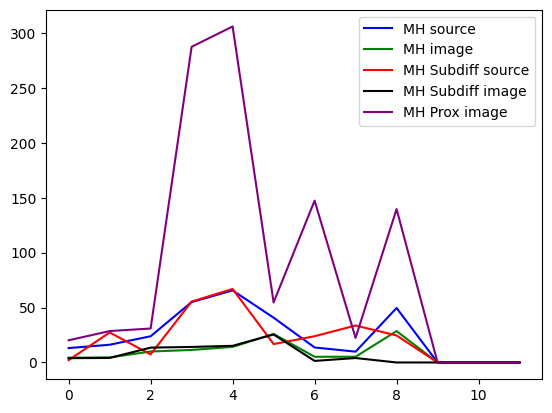

In [13]:
plt.figure()
plt.plot(errors_source, color = "blue", label="MH source")
plt.plot(errors_image, color = "green", label="MH image")
plt.plot(errors_subdiff_source, color = "red", label="MH Subdiff source")
plt.plot(errors_subdiff_image, color = "black", label="MH Subdiff image")
# plt.plot(errors_prox_source, color = "cyan", label="MH Prox source")
plt.plot(errors_prox_image, color = "purple", label="MH Prox image")
plt.legend()
plt.show()

Comparaison pour plusieurs valeurs de Lambda, erreur en norme 1 entre les moyennes empiriques et les moyennes théoriques pour différentes méthodes. Les moyennes empiriques sont obtenues après 10^5 itérations, une fois burn-in fini. La méthode source, image, subdiff_image fournissent des résultats similaires, la méthode subdiff_source fournit des résultats beaucoup moins bons : la convergence prend beaucoup de temps, ou, plus probable, il y a un problème dans la formulation de la méthode.